# 13__motif_chip_tf_ts_redo
# testing whether gene tissue-sp correlates with chip/motif tissue-sp

after talking to lucas: find tissue-sp for each TF, find all genes that have that motif/chip peak, calc. average tissue-sp. of those genes, correlate that with the tissue-sp. (and subset by class, if needed)

chip and fimo files are from PJ

took fimo mappings from marta's directory

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from os import walk
from scipy.stats import spearmanr

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## functions

In [3]:
def get_tss_id(row):
    if "Enhancer" in row.tss_name:
        return row.tss_name.split("__")[1]
    else:
        return row.tss_name.split("__")[2]

## variables
### tissue specificities

In [4]:
tss_ts_f = "TSS.CAGE_grouped_exp.tissue_sp.txt"
enh_ts_f = "Enh.CAGE_grouped_exp.tissue_sp.txt"

In [5]:
tf_ts_f = "TF_tissue_specificities.from_CAGE.txt"

### for all promoters (3kb)

In [6]:
chip_f = "chip_all.txt"

In [7]:
fimo_f = "fimo_all_biotypes.txt"

In [8]:
annot_f = "../../misc/00__tss_properties/TSS_FantomCat_all.TSSperENSG.txt"

### for all promoters (114bp)

In [9]:
chip_114_f = "chip_all_114.txt"

In [10]:
fimo_114_f = "../../misc/05__fimo/TFmotifs__intersect_114bpTSS.uniq.txt"

### pool1 tss

In [11]:
pool1_annot_f = "../../misc/00__tss_properties/TABLE_ALL_TSS_and_flipped.properties.PromType.txt"

## 1. import data

In [12]:
fimo = pd.read_table(fimo_f, sep="\t")
fimo = fimo[fimo["shuffled"] != "shuffled"]
fimo.head()

,#pattern name,short_description,tss_id,shuffled,start,stop,strand,score,p-value,q-value,matched sequence,motif_id,biotype
2533673,RUNX1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,15,25,+,15.6034,2.490000e-07,0.338,gtctgtggttt,RUNX1,protein_coding
2533674,RUNX1,NaN,"chr2:66610364..66610365,+",NaN,13,23,-,15.6034,2.490000e-07,0.338,GTCTGTGGTTT,RUNX1,intergenic
2533675,RUNX1,NaN,"chr6:29424953..29424961,+",NaN,47,57,-,15.6034,2.490000e-07,0.338,GTCTGTGGTTT,RUNX1,protein_coding
2533676,RUNX1,p1@ENST00000412759,"chr1:120838328..120838358,-",NaN,169,179,-,15.6034,2.490000e-07,0.338,GTCTGTGGTTT,RUNX1,div_lnc
2533677,RUNX1,p1@TXNDC11,"chr16:11836595..11836726,-",NaN,235,245,-,15.6034,2.490000e-07,0.338,GTCTGTGGTTT,RUNX1,div_pc


In [13]:
chip = pd.read_table(chip_f, sep="\t")
chip.head()

,chromosome,start,end,short_description,tss_id,score,strand,chip_id,chip_chromosome,chip_start,chip_end,chip_score,biotype,pos,pos_rel,motif_id
0,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ARID3A,chr1,10003524,10003525,24.543343,div_pc,10003524.5,-139.5,ARID3A
1,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003413,10003414,42.461327,div_pc,10003413.5,-28.5,ATF2
2,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003497,10003498,69.683125,div_pc,10003497.5,-112.5,ATF2
3,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF3,chr1,10003457,10003458,27.073183,div_pc,10003457.5,-72.5,ATF3
4,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,BCL3,chr1,10003424,10003425,55.235219,div_pc,10003424.5,-39.5,BCL3


In [14]:
annot = pd.read_table(annot_f, sep="\t")
promtype2 = annot[["gene_id", "PromType2"]].drop_duplicates()
promtype2.head()

,gene_id,PromType2
0,ENSG00000000003.10,protein_coding
8,ENSG00000000005.5,protein_coding
13,ENSG00000000419.8,protein_coding
17,ENSG00000000457.9,protein_coding
24,ENSG00000000460.12,protein_coding


In [15]:
tf_ts = pd.read_table(tf_ts_f, sep="\t")
tf_ts.head()

,tf,tissue_sp_all,tissue_sp_3
0,CEBPD,0.921694,0.413813
1,NFATC1,0.948779,0.658046
2,GTF2F1,0.651180,0.097383
3,RORA,0.925755,0.666667
4,BCL6B,0.969175,0.666667


In [20]:
tss_ts = pd.read_table(tss_ts_f, sep="\t")
tss_ts.head()

,00Annotation,short_description,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,...,Group_542,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3
0,"chr10:100013403..100013414,-","p@chr10:100013403..100013414,-",0.54300,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.993829,0.666667
1,"chr10:100027943..100027958,-",p1@LOXL4,27.14998,0.89047,0.0,0.0,0.0,0.1056,0.0,0.101989,...,0.0,0.000000,0.0,0.0,1.603423,2.000139,0.629078,0.0,0.968756,0.666667
2,"chr10:100076685..100076699,+","p@chr10:100076685..100076699,+",0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.984646,NaN
3,"chr10:100150910..100150935,-","p@chr10:100150910..100150935,-",0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,0.548168,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.991970,NaN
4,"chr10:100150951..100150962,-","p@chr10:100150951..100150962,-",0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,1.096335,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.981522,NaN


In [17]:
enh_ts = pd.read_table(enh_ts_f, sep="\t")
enh_ts.head()

,Id,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,...,Group_542,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3
0,chr1:839741-840250,0.0,0.216714,0.0,0.0,0.000000,0.102923,0.000000,0.0,0.0,...,0.0,0.00000,0.306431,0.206949,0.0,0.38338,0.087482,0.110784,0.981674,0.483654
1,chr1:840753-841210,0.0,0.216714,0.0,0.0,0.000000,0.000000,0.543603,0.0,0.0,...,0.0,0.13168,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.984912,0.483654
2,chr1:845485-845678,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.181201,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.990033,0.666667
3,chr1:855764-856157,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.990598,0.666667
4,chr1:856539-856757,0.0,0.000000,0.0,0.0,0.199924,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.087482,0.000000,0.977400,0.479531


In [21]:
tss_ts.drop("short_description", axis=1, inplace=True)
tss_ts_cols = ["Id"]
sample_cols = [x for x in tss_ts.columns if "Group_" in x or "tissue_sp_" in x]
tss_ts_cols.extend(sample_cols)
tss_ts.columns = tss_ts_cols
tss_ts.head()

,Id,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,...,Group_542,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3
0,"chr10:100013403..100013414,-",0.54300,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.993829,0.666667
1,"chr10:100027943..100027958,-",27.14998,0.89047,0.0,0.0,0.0,0.1056,0.0,0.101989,0.000000,...,0.0,0.000000,0.0,0.0,1.603423,2.000139,0.629078,0.0,0.968756,0.666667
2,"chr10:100076685..100076699,+",0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.210998,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.984646,NaN
3,"chr10:100150910..100150935,-",0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,...,0.0,0.548168,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.991970,NaN
4,"chr10:100150951..100150962,-",0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,...,0.0,1.096335,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.981522,NaN


In [22]:
all_ts = tss_ts.append(enh_ts)
all_ts.sample(5)

,Id,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,...,Group_542,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3
90175,"chr1:224363656..224363657,-",3.800997,0.111309,1.164959,5.399660,4.233472,0.10560,2.994249,2.549721,12.026890,...,0.000000,3.151964,1.638049,2.348964,0.801711,5.200361,0.179737,0.341826,0.905908,0.317360
15093,chr12:120080327-120080462,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.991906,NaN
187612,"chr9:102861515..102861592,+",7.058995,16.028454,17.474392,10.199357,9.736985,9.29283,8.982746,6.119330,11.182897,...,14.606031,7.400264,6.552197,11.632965,11.223959,10.400722,13.030911,13.217278,0.790747,0.089366
94522,"chr1:44088128..44088134,+",0.000000,0.333926,0.000000,0.000000,0.000000,0.10560,0.187141,0.611933,0.210998,...,0.471162,0.411126,0.000000,0.335566,0.000000,0.000000,0.629078,0.341826,0.975923,0.339629
68028,"chr18:57365219..57365228,-",3.257998,0.111309,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.801711,2.400167,0.000000,0.000000,0.968983,NaN


In [23]:
chip_114 = pd.read_table(chip_114_f, sep="\t", header=None)
chip_114.columns = ["tss_chr", "tss_start", "tss_end", "tss_name", "tss_score", "tss_strand", "motif_chr",
                    "motif_start", "motif_end", "motif_score", "motif_id", "cell", "overlap"]
chip_114["tss_id"] = chip_114.apply(get_tss_id, axis=1)
chip_114.sample(5)

,tss_chr,tss_start,tss_end,tss_name,tss_score,tss_strand,motif_chr,motif_start,motif_end,motif_score,motif_id,cell,overlap,tss_id
798257,chrX,100184445,100184560,"protein_coding__NA__chrX:100184473..100184487,-",0,-,chrX,100184535,100184536,31.146359,SP1,GM12878,1,"chrX:100184473..100184487,-"
11056,chr1,145575206,145575321,protein_coding__p1@PIAS3__chr1:145575227..1455...,0,+,chr1,145575312,145575313,222.631760,POLR2A,A549,1,"chr1:145575227..145575319,+"
163328,chr11,9286855,9286970,protein_coding__p1@DENND5A__chr11:9286848..928...,0,-,chr11,9286877,9286878,134.642519,CTCF,GM12892,1,"chr11:9286848..9286920,-"
394039,chr19,19144616,19144731,protein_coding__p2@SUGP2__chr19:19144609..1914...,0,-,chr19,19144713,19144714,212.359949,MAX,HeLa-S3,1,"chr19:19144609..19144671,-"
615202,chr5,118788111,118788226,protein_coding__p1@HSD17B4__chr5:118788182..11...,0,+,chr5,118788115,118788116,167.595352,ZNF143,H1-hESC,1,"chr5:118788182..118788255,+"


In [24]:
fimo_114 = pd.read_table(fimo_114_f, sep="\t", header=None)
fimo_114.columns = ["tss_chr", "tss_start", "tss_end", "tss_name", "tss_score", "tss_strand", "motif_chr",
                    "motif_start", "motif_end", "motif_id", "motif_score", "motif_strand"]
fimo_114["tss_id"] = fimo_114.apply(get_tss_id, axis=1)
fimo_114.head()

,tss_chr,tss_start,tss_end,tss_name,tss_score,tss_strand,motif_chr,motif_start,motif_end,motif_id,motif_score,motif_strand,tss_id
0,chr1,10003350,10003351,"div_pc__p1@LZIC__chr1:10003372..10003465,-",0,-,chr1,10003338,10003351,NFKB1,7.63265,-,"chr1:10003372..10003465,-"
1,chr1,10003350,10003351,"div_pc__p1@LZIC__chr1:10003372..10003465,-",0,-,chr1,10003338,10003351,NFKB2,13.00000,+,"chr1:10003372..10003465,-"
2,chr1,10003350,10003351,"div_pc__p1@LZIC__chr1:10003372..10003465,-",0,-,chr1,10003338,10003351,NFKB2,7.42424,-,"chr1:10003372..10003465,-"
3,chr1,10003350,10003352,"div_pc__p1@LZIC__chr1:10003372..10003465,-",0,-,chr1,10003339,10003352,NFKB1,3.24490,-,"chr1:10003372..10003465,-"
4,chr1,10003350,10003352,"div_pc__p1@LZIC__chr1:10003372..10003465,-",0,-,chr1,10003339,10003352,NFKB1,3.38776,+,"chr1:10003372..10003465,-"


In [25]:
pool1_annot = pd.read_table(pool1_annot_f, sep="\t")
pool1_annot.head()

,gene_id,TSS_associated_1st.transc_id,oligo_reg,TSS_id,TSS_description,TSS_transc_association,avExpALL,gene_name,gene_type,GeneType,...,rs.SNP1,rs.SNP2,R.squared,Distance,trait,n.eQTLs,n.eQTLs94,PromType,PromType2,PromType3
0,ENSG00000000419.8,ENST00000371583,"chr20:49575034..49575148,-","chr20:49575059..49575077,-",p1@DPM1,"0bp_to_ENST00000371583,ENST00000413082,ENST000...",71.110566,DPM1,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
1,ENSG00000002586.13,ENST00000381187,"chrX:2609217..2609331,+","chrX:2609278..2609302,+",p3@CD99,-14bp_to_ENST00000381187_5end,17.394880,CD99,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
2,ENSG00000002919.10,ENST00000359238,"chr17:46184858..46184972,+","chr17:46184920..46184951,+",p2@SNX11,"0bp_to_ENST00000359238,ENST00000393405,ENST000...",4.722549,SNX11,protein_coding,protein_coding,...,rs72823592,rs16952265,0.844249196799263,-61879,Epilepsy_(generalized),2,2,protein_coding,protein_coding,protein_coding
3,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,-","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
4,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,+","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding


## 2. merge fimo/chip with tss tissue-sp values

In [26]:
all_ts = all_ts[["Id", "tissue_sp_all", "tissue_sp_3"]]
all_ts.columns = ["tss_id", "tissue_spec_all_cage", "tissue_spec_three_cage"]
all_ts.sample(5)

,tss_id,tissue_spec_all_cage,tissue_spec_three_cage
5185,"chr10:52383644..52383742,-",0.813923,0.458074
899,"chr10:11059946..11059958,+",0.957869,NaN
161092,"chr6:159463538..159463554,+",0.985880,NaN
4863,chr1:208377298-208378003,0.983815,NaN
39012,chr22:31631095-31631484,0.996419,NaN


In [27]:
len(fimo)

4455254

In [28]:
fimo_ts = fimo.merge(all_ts, on="tss_id")
print(len(fimo_ts))
fimo_ts.sample(5)

4022465


,#pattern name,short_description,tss_id,shuffled,start,stop,strand,score,p-value,q-value,matched sequence,motif_id,biotype,tissue_spec_all_cage,tissue_spec_three_cage
1162058,MEF2A,NaN,chr1:212731490-212732709,NaN,1873,1884,+,14.2258,0.000008,0.425,GCTAAAATTAGC,MEF2A,enhancer,0.911724,0.548008
1817900,TFAP2C,NaN,chr22:37219328-37219591,NaN,2869,2880,+,13.6837,0.000010,0.315,GGCCCCAAGGCA,TFAP2C,enhancer,0.994678,NaN
3851550,NFKB2,NaN,chr2:173909393-173909689,NaN,826,838,-,16.2727,0.000002,0.391,AGGGAATTTCCCT,NFKB2,enhancer,0.987881,NaN
3271622,Foxk1,NaN,chr3:7836263-7836282,NaN,2260,2276,-,15.0260,0.000005,0.479,ATAATATAAACAAGGAT,Foxk1,enhancer,0.994387,NaN
127144,Rarb,p2@AKNA,"chr9:117160738..117160782,-",NaN,142,157,-,4.0000,0.000009,0.276,TTAGGTTAAAAGTTCT,Rarb,intergenic,0.942440,0.200186


In [29]:
missing_tss_ids_fimo = fimo[~fimo["tss_id"].isin(all_ts["tss_id"])]["tss_id"].unique()
len(missing_tss_ids_fimo)

7625

In [30]:
len(chip)

5940131

In [31]:
chip_ts = chip.merge(all_ts, on="tss_id")
print(len(chip_ts))
chip_ts.sample(5)

5292996


,chromosome,start,end,short_description,tss_id,score,strand,chip_id,chip_chromosome,chip_start,chip_end,chip_score,biotype,pos,pos_rel,motif_id,tissue_spec_all_cage,tissue_spec_three_cage
2965820,chr1,28414982,28417982,NaN,chr1:28416909-28416983,0,+,E2F1,chr1,28415356,28415357,46.908032,enhancer,28415356.5,-1625.5,E2F1,0.992728,NaN
4298390,chr20,49452395,49455395,NaN,chr20:49454379-49454475,0,+,POLR2A,chr20,49454285,49454286,50.476328,enhancer,49454285.5,-109.5,POLR2A,0.980017,NaN
1597059,chr2,27850867,27853867,p1@CCDC121,"chr2:27851843..27851885,-",0,-,SIN3AK20,chr2,27851878,27851879,49.230716,protein_coding,27851878.5,-11.5,SIN3AK20,0.958044,0.125684
3689815,chr16,81762244,81765244,NaN,chr16:81763852-81764387,0,+,MAZ,chr16,81764033,81764034,39.101340,enhancer,81764033.5,-210.5,MAZ,0.966803,0.602784
2239284,chr6,138427587,138430587,p2@PERP,"chr6:138428580..138428599,-",0,-,UBTF,chr6,138428602,138428603,59.124642,protein_coding,138428602.5,-15.5,UBTF,0.900368,0.354647


In [32]:
missing_tss_ids_chip = chip[~chip["tss_id"].isin(all_ts["tss_id"])]["tss_id"].unique()
len(missing_tss_ids_chip)

6473

In [33]:
fimo_114_ts = fimo_114.merge(all_ts, on="tss_id")
print(len(fimo_114_ts))
fimo_114_ts.sample(5)

1088062


,tss_chr,tss_start,tss_end,tss_name,tss_score,tss_strand,motif_chr,motif_start,motif_end,motif_id,motif_score,motif_strand,tss_id,tissue_spec_all_cage,tissue_spec_three_cage
365235,chr4,87515428,87515439,protein_coding__p1@PTPN13__chr4:87515454..8751...,0,+,chr4,87515428,87515439,NRF1,13.5636,+,"chr4:87515454..87515486,+",0.967402,0.666667
491878,chr1,101863567,101863582,Enhancer__chr1:101863321-101863580,0,+,chr1,101863567,101863582,MEF2C,12.8136,-,chr1:101863321-101863580,0.987531,NaN
524841,chr1,232726334,232726345,Enhancer__chr1:232726243-232726385,0,+,chr1,232726334,232726345,Gabpa,11.1148,-,chr1:232726243-232726385,0.993924,NaN
228112,chr19,17622450,17622461,"div_pc__p1@PGLS__chr19:17622415..17622481,+",0,+,chr19,17622450,17622461,ELK4,10.9455,+,"chr19:17622415..17622481,+",0.797264,0.418158
219304,chr18,63273260,63273274,"intergenic__p@chr18:63273310..63273317,+__chr1...",0,+,chr18,63273260,63273274,EGR1,13.4808,-,"chr18:63273310..63273317,+",0.994162,0.641151


In [34]:
chip_114_ts = chip_114.merge(all_ts, on="tss_id")
print(len(chip_114_ts))
chip_114_ts.sample(5)

947043


,tss_chr,tss_start,tss_end,tss_name,tss_score,tss_strand,motif_chr,motif_start,motif_end,motif_score,motif_id,cell,overlap,tss_id,tissue_spec_all_cage,tissue_spec_three_cage
332886,chr19,12834711,12834826,protein_coding__p1@TNPO2__chr19:12834739..1283...,0,-,chr19,12834791,12834792,115.961036,E2F6,K562,1,"chr19:12834739..12834806,-",0.804765,0.165432
86181,chr10,25305473,25305588,protein_coding__p1@THNSL1__chr10:25305524..253...,0,+,chr10,25305523,25305524,51.479930,MAX,H1-hESC,1,"chr10:25305524..25305595,+",0.775755,0.396977
585297,chr6,30688048,30688163,protein_coding__p1@TUBB__chr6:30688119..306881...,0,+,chr6,30688136,30688137,26.545995,PAX5,GM12892,1,"chr6:30688119..30688141,+",0.743666,0.222743
742162,chr10,81077646,81077761,Enhancer__chr10:81077317-81078576,0,+,chr10,81077692,81077693,24.775967,SIN3AK20,SK-N-SH,1,chr10:81077317-81078576,0.982775,0.666667
759922,chr12,4255607,4255722,Enhancer__chr12:4255485-4255796,0,+,chr12,4255656,4255657,88.290245,BHLHE40,GM12878,1,chr12:4255485-4255796,0.991289,NaN


## 3. map tissue spec per TF

In [36]:
tf_ts.columns = ["tf", "TF_tissue_spec_all", "TF_tissue_spec_three"]
tf_ts.head()

,tf,TF_tissue_spec_all,TF_tissue_spec_three
0,CEBPD,0.921694,0.413813
1,NFATC1,0.948779,0.658046
2,GTF2F1,0.651180,0.097383
3,RORA,0.925755,0.666667
4,BCL6B,0.969175,0.666667


In [37]:
chip_ts["motif_upper"] = chip_ts["motif_id"].str.upper()
chip_114_ts["motif_upper"] = chip_114_ts["motif_id"].str.upper()
chip_ts.head()

,chromosome,start,end,short_description,tss_id,score,strand,chip_id,chip_chromosome,chip_start,chip_end,chip_score,biotype,pos,pos_rel,motif_id,tissue_spec_all_cage,tissue_spec_three_cage,motif_upper
0,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ARID3A,chr1,10003524,10003525,24.543343,div_pc,10003524.5,-139.5,ARID3A,0.737084,0.14485,ARID3A
1,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003413,10003414,42.461327,div_pc,10003413.5,-28.5,ATF2,0.737084,0.14485,ATF2
2,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003497,10003498,69.683125,div_pc,10003497.5,-112.5,ATF2,0.737084,0.14485,ATF2
3,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF3,chr1,10003457,10003458,27.073183,div_pc,10003457.5,-72.5,ATF3,0.737084,0.14485,ATF3
4,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,BCL3,chr1,10003424,10003425,55.235219,div_pc,10003424.5,-39.5,BCL3,0.737084,0.14485,BCL3


In [38]:
chip_ts = chip_ts.merge(tf_ts, left_on="motif_upper", right_on="tf", how="left")
chip_114_ts = chip_114_ts.merge(tf_ts, left_on="motif_upper", right_on="tf", how="left")
chip_ts.head()

,chromosome,start,end,short_description,tss_id,score,strand,chip_id,chip_chromosome,chip_start,...,biotype,pos,pos_rel,motif_id,tissue_spec_all_cage,tissue_spec_three_cage,motif_upper,tf,TF_tissue_spec_all,TF_tissue_spec_three
0,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ARID3A,chr1,10003524,...,div_pc,10003524.5,-139.5,ARID3A,0.737084,0.14485,ARID3A,ARID3A,0.939887,0.485883
1,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003413,...,div_pc,10003413.5,-28.5,ATF2,0.737084,0.14485,ATF2,ATF2,0.689425,0.345769
2,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF2,chr1,10003497,...,div_pc,10003497.5,-112.5,ATF2,0.737084,0.14485,ATF2,ATF2,0.689425,0.345769
3,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,ATF3,chr1,10003457,...,div_pc,10003457.5,-72.5,ATF3,0.737084,0.14485,ATF3,ATF3,0.922749,0.390487
4,chr1,10002385,10005385,p1@LZIC,"chr1:10003372..10003465,-",0,-,BCL3,chr1,10003424,...,div_pc,10003424.5,-39.5,BCL3,0.737084,0.14485,BCL3,BCL3,0.970477,0.410355


In [39]:
fimo_ts["motif_upper"] = fimo_ts["motif_id"].str.upper()
fimo_114_ts["motif_upper"] = fimo_114_ts["motif_id"].str.upper()
fimo_ts.head()

,#pattern name,short_description,tss_id,shuffled,start,stop,strand,score,p-value,q-value,matched sequence,motif_id,biotype,tissue_spec_all_cage,tissue_spec_three_cage,motif_upper
0,RUNX1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,15,25,+,15.6034,2.490000e-07,0.338,gtctgtggttt,RUNX1,protein_coding,0.798632,0.059162,RUNX1
1,TFAP2A,p1@SYVN1,"chr11:64901978..64902009,-",NaN,1604,1614,+,13.8909,9.460000e-06,0.155,CCCCTCAGGCT,TFAP2A,protein_coding,0.798632,0.059162,TFAP2A
2,PAX5,p1@SYVN1,"chr11:64901978..64902009,-",NaN,638,656,+,14.5484,5.460000e-06,0.107,ctgggcgacagagcaagac,PAX5,protein_coding,0.798632,0.059162,PAX5
3,E2F1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,616,627,+,14.1475,8.620000e-06,1.000,gatggcgccaat,E2F1,protein_coding,0.798632,0.059162,E2F1
4,ELK1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,1947,1956,+,16.2128,3.920000e-06,0.605,gccggAAGTG,ELK1,protein_coding,0.798632,0.059162,ELK1


In [40]:
fimo_ts = fimo_ts.merge(tf_ts, left_on="motif_upper", right_on="tf", how="left")
fimo_114_ts = fimo_114_ts.merge(tf_ts, left_on="motif_upper", right_on="tf", how="left")
fimo_ts.head()

,#pattern name,short_description,tss_id,shuffled,start,stop,strand,score,p-value,q-value,matched sequence,motif_id,biotype,tissue_spec_all_cage,tissue_spec_three_cage,motif_upper,tf,TF_tissue_spec_all,TF_tissue_spec_three
0,RUNX1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,15,25,+,15.6034,2.490000e-07,0.338,gtctgtggttt,RUNX1,protein_coding,0.798632,0.059162,RUNX1,RUNX1,0.889490,0.413074
1,TFAP2A,p1@SYVN1,"chr11:64901978..64902009,-",NaN,1604,1614,+,13.8909,9.460000e-06,0.155,CCCCTCAGGCT,TFAP2A,protein_coding,0.798632,0.059162,TFAP2A,TFAP2A,0.917275,0.666587
2,PAX5,p1@SYVN1,"chr11:64901978..64902009,-",NaN,638,656,+,14.5484,5.460000e-06,0.107,ctgggcgacagagcaagac,PAX5,protein_coding,0.798632,0.059162,PAX5,PAX5,0.989766,NaN
3,E2F1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,616,627,+,14.1475,8.620000e-06,1.000,gatggcgccaat,E2F1,protein_coding,0.798632,0.059162,E2F1,E2F1,0.886909,0.325681
4,ELK1,p1@SYVN1,"chr11:64901978..64902009,-",NaN,1947,1956,+,16.2128,3.920000e-06,0.605,gccggAAGTG,ELK1,protein_coding,0.798632,0.059162,ELK1,ELK1,0.747016,0.404140


## 4. find avg tissue-specifity of TFs within a given gene
### for both chip and fimo, both all samples and 3 samples only

#### chip -- all promoters -- 3kb -- all CAGE

In [41]:
chip_ts_sub = chip_ts[(~pd.isnull(chip_ts["tissue_spec_all_cage"])) & (~pd.isnull(chip_ts["TF_tissue_spec_all"]))]

In [42]:
chip_grp_all = chip_ts_sub.groupby(["tss_id", "tissue_spec_all_cage"])["TF_tissue_spec_all"].agg(["mean", "count"]).reset_index()
chip_grp_all.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]
chip_grp_all.head()

,tss_id,tss_ts,tf_ts,tf_count
0,chr10:100019738-100019959,0.988554,0.939995,21
1,chr10:100020230-100020246,0.989496,0.939995,21
2,"chr10:100027943..100027958,-",0.968756,0.896389,62
3,chr10:100074404-100074582,0.993289,0.902173,44
4,chr10:100076038-100076149,0.995153,0.910323,43


In [43]:
len(chip_grp_all)

71664

#### fimo -- all promoters -- 3kb -- all CAGE

In [44]:
fimo_ts_sub = fimo_ts[(~pd.isnull(fimo_ts["tissue_spec_all_cage"])) & (~pd.isnull(fimo_ts["TF_tissue_spec_all"]))]

In [45]:
fimo_grp_all = fimo_ts_sub.groupby(["tss_id", "tissue_spec_all_cage"])["TF_tissue_spec_all"].agg(["mean", "count"]).reset_index()
fimo_grp_all.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]
fimo_grp_all.head()

,tss_id,tss_ts,tf_ts,tf_count
0,chr10:100019738-100019959,0.988554,0.875316,69
1,chr10:100020230-100020246,0.989496,0.874616,68
2,"chr10:100027943..100027958,-",0.968756,0.841719,77
3,chr10:100074404-100074582,0.993289,0.907300,41
4,chr10:100076038-100076149,0.995153,0.929257,44


In [46]:
len(fimo_grp_all)

82353

#### chip -- all promoters -- 114bp -- all CAGE

In [47]:
chip_114_ts_sub = chip_114_ts[(~pd.isnull(chip_114_ts["tissue_spec_all_cage"])) & (~pd.isnull(chip_114_ts["TF_tissue_spec_all"]))]

In [48]:
chip_114_grp_all = chip_114_ts_sub.groupby(["tss_id", "tissue_spec_all_cage"])["TF_tissue_spec_all"].agg(["mean", "count"]).reset_index()
chip_114_grp_all.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]
chip_114_grp_all.head()

,tss_id,tss_ts,tf_ts,tf_count
0,"chr10:100027943..100027958,-",0.968756,0.768251,3
1,chr10:100074404-100074582,0.993289,0.895179,22
2,chr10:100076500-100076699,0.981128,0.919828,5
3,chr10:100082942-100083374,0.986789,0.869777,36
4,chr10:100120877-100121283,0.958970,0.768251,2


In [49]:
len(chip_114_grp_all)

29376

#### fimo -- all promoters -- 114bp -- all CAGE

In [50]:
fimo_114_ts_sub = fimo_114_ts[(~pd.isnull(fimo_114_ts["tissue_spec_all_cage"])) & (~pd.isnull(fimo_114_ts["TF_tissue_spec_all"]))]

In [51]:
fimo_114_grp_all = fimo_114_ts_sub.groupby(["tss_id", "tissue_spec_all_cage"])["TF_tissue_spec_all"].agg(["mean", "count"]).reset_index()
fimo_114_grp_all.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]
fimo_114_grp_all.head()

,tss_id,tss_ts,tf_ts,tf_count
0,"chr10:100027943..100027958,-",0.968756,0.904799,14
1,chr10:100074404-100074582,0.993289,0.911687,20
2,chr10:100076038-100076149,0.995153,0.883517,19
3,chr10:100076500-100076699,0.981128,0.926827,18
4,chr10:100082942-100083374,0.986789,0.894545,32


In [52]:
len(fimo_114_grp_all)

47259

#### chip -- all promoters -- 3kb -- 3 cell-line CAGE

In [53]:
chip_ts_sub = chip_ts[(~pd.isnull(chip_ts["tissue_spec_three_cage"])) & (~pd.isnull(chip_ts["TF_tissue_spec_three"]))]

In [54]:
chip_grp_3 = chip_ts_sub.groupby(["tss_id", "tissue_spec_three_cage"])["TF_tissue_spec_three"].agg(["mean", "count"]).reset_index()
chip_grp_3.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]
chip_grp_3.head()

,tss_id,tss_ts,tf_ts,tf_count
0,chr10:100020230-100020246,0.666667,0.378476,21
1,"chr10:100027943..100027958,-",0.666667,0.333300,54
2,chr10:100074404-100074582,0.666667,0.336819,39
3,chr10:100082942-100083374,0.666667,0.302495,69
4,chr10:100120877-100121283,0.666667,0.301072,38


In [55]:
len(chip_grp_3)

35097

#### fimo -- all promoters -- 3kb -- 3 cell-line CAGE

In [56]:
fimo_ts_sub = fimo_ts[(~pd.isnull(fimo_ts["tissue_spec_three_cage"])) & (~pd.isnull(fimo_ts["TF_tissue_spec_three"]))]

In [57]:
fimo_grp_3 = fimo_ts_sub.groupby(["tss_id", "tissue_spec_three_cage"])["TF_tissue_spec_three"].agg(["mean", "count"]).reset_index()
fimo_grp_3.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]
fimo_grp_3.head()

,tss_id,tss_ts,tf_ts,tf_count
0,chr10:100020230-100020246,0.666667,0.410849,63
1,"chr10:100027943..100027958,-",0.666667,0.392515,72
2,chr10:100074404-100074582,0.666667,0.440817,35
3,chr10:100082942-100083374,0.666667,0.401243,15
4,chr10:100120877-100121283,0.666667,0.479159,23


In [58]:
len(fimo_grp_3)

38089

#### chip -- all promoters -- 114bp -- 3 cell-line CAGE

In [59]:
chip_114_ts_sub = chip_114_ts[(~pd.isnull(chip_114_ts["tissue_spec_three_cage"])) & (~pd.isnull(chip_114_ts["TF_tissue_spec_three"]))]

In [60]:
chip_114_grp_3 = chip_114_ts_sub.groupby(["tss_id", "tissue_spec_three_cage"])["TF_tissue_spec_three"].agg(["mean", "count"]).reset_index()
chip_114_grp_3.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]
chip_114_grp_3.head()

,tss_id,tss_ts,tf_ts,tf_count
0,"chr10:100027943..100027958,-",0.666667,0.056071,3
1,chr10:100074404-100074582,0.666667,0.341921,22
2,chr10:100082942-100083374,0.666667,0.282484,36
3,chr10:100120877-100121283,0.666667,0.056071,2
4,"chr10:100174900..100174956,-",0.547032,0.161597,69


In [61]:
len(chip_114_grp_3)

18687

#### fimo -- all promoters -- 114bp -- 3 cell-line CAGE

In [62]:
fimo_114_ts_sub = fimo_114_ts[(~pd.isnull(fimo_114_ts["tissue_spec_three_cage"])) & (~pd.isnull(fimo_114_ts["TF_tissue_spec_three"]))]

In [63]:
fimo_114_grp_3 = fimo_114_ts_sub.groupby(["tss_id", "tissue_spec_three_cage"])["TF_tissue_spec_three"].agg(["mean", "count"]).reset_index()
fimo_114_grp_3.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]
fimo_114_grp_3.head()

,tss_id,tss_ts,tf_ts,tf_count
0,"chr10:100027943..100027958,-",0.666667,0.493719,13
1,chr10:100074404-100074582,0.666667,0.489769,20
2,chr10:100082942-100083374,0.666667,0.404621,26
3,chr10:100120877-100121283,0.666667,0.370536,8
4,"chr10:100174900..100174956,-",0.547032,0.430676,14


In [64]:
len(fimo_114_grp_3)

22587

## 5. plot the scatters

In [65]:
cmap = sns.light_palette("darkslategray", as_cmap=True)

In [66]:
tf_ts.sort_values(by="TF_tissue_spec_all").tail()

,tf,TF_tissue_spec_all,TF_tissue_spec_three
119,POU4F3,0.996951,NaN
245,SPZ1,0.997306,NaN
362,T,0.997828,NaN
377,DMBX1,0.998014,NaN
71,POU1F1,0.998152,NaN


#### chip -- all promoters -- 3kb -- 3 cell-line CAGE

In [72]:
# fig = plt.figure(figsize=(1.2, 1.2))
# ax = sns.kdeplot(chip_grp_all["tf_ts"], chip_grp_all["tss_ts"], cmap=cmap, 
#                  shade=True, shade_lowest=False)
# ax.set_xlabel("mean(tissue-specificity of TFs w/ peak in TSS)")
# ax.set_ylabel("tissue-specificity of TSS")

# r, p = stats.spearmanr(chip_grp_all["tf_ts"], chip_grp_all["tss_ts"])
# print("r: %s, spearman p: %s" % (r, p))
# ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

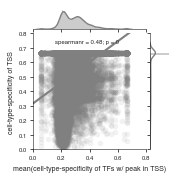

In [75]:
g = sns.jointplot(data=chip_grp_3, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0, 0.8), ylim=(0,0.8), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(cell-type-specificity of TFs w/ peak in TSS)", "cell-type-specificity of TSS")
g.savefig("chip_allTSS_3kb_3CAGE_corr.pdf", dpi="figure", bbox_inches="tight")

#### chip -- all promoters -- 3kb -- all CAGE

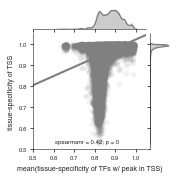

In [77]:
g = sns.jointplot(data=chip_grp_all, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0.5, 1.05), ylim=(0.5,1.05), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(tissue-specificity of TFs w/ peak in TSS)", "tissue-specificity of TSS")
g.savefig("chip_allTSS_3kb_allCAGE_corr.pdf", dpi="figure", bbox_inches="tight")

#### chip -- all promoters -- 114bp -- 3 cell-line CAGE

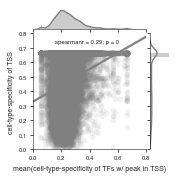

In [79]:
g = sns.jointplot(data=chip_114_grp_3, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0, 0.8), ylim=(0,0.8), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(cell-type-specificity of TFs w/ peak in TSS)", "cell-type-specificity of TSS")
g.savefig("chip_allTSS_114bp_3CAGE_corr.pdf", dpi="figure", bbox_inches="tight")

#### chip -- all promoters -- 114bp -- all CAGE

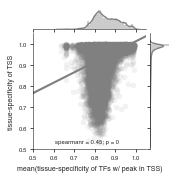

In [81]:
g = sns.jointplot(data=chip_114_grp_all, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0.5, 1.05), ylim=(0.5,1.05), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(tissue-specificity of TFs w/ peak in TSS)", "tissue-specificity of TSS")
g.savefig("chip_allTSS_114bp_allCAGE_corr.pdf", dpi="figure", bbox_inches="tight")

#### fimo -- all promoters -- 3kb -- 3 cell-line CAGE

In [72]:
# fig = plt.figure(figsize=(1.2, 1.2))
# ax = sns.kdeplot(chip_grp_all["tf_ts"], chip_grp_all["tss_ts"], cmap=cmap, 
#                  shade=True, shade_lowest=False)
# ax.set_xlabel("mean(tissue-specificity of TFs w/ peak in TSS)")
# ax.set_ylabel("tissue-specificity of TSS")

# r, p = stats.spearmanr(chip_grp_all["tf_ts"], chip_grp_all["tss_ts"])
# print("r: %s, spearman p: %s" % (r, p))
# ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

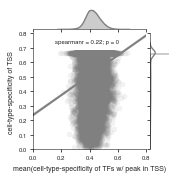

In [82]:
g = sns.jointplot(data=fimo_grp_3, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0, 0.8), ylim=(0,0.8), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(cell-type-specificity of TFs w/ peak in TSS)", "cell-type-specificity of TSS")
g.savefig("fimo_allTSS_3kb_3CAGE_corr.pdf", dpi="figure", bbox_inches="tight")

#### fimo -- all promoters -- 3kb -- all CAGE

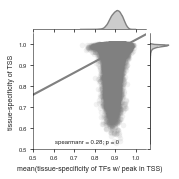

In [83]:
g = sns.jointplot(data=fimo_grp_all, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0.5, 1.05), ylim=(0.5,1.05), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(tissue-specificity of TFs w/ peak in TSS)", "tissue-specificity of TSS")
g.savefig("fimo_allTSS_3kb_allCAGE_corr.pdf", dpi="figure", bbox_inches="tight")

#### fimo -- all promoters -- 114bp -- 3 cell-line CAGE

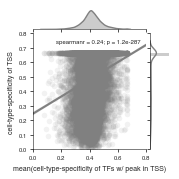

In [84]:
g = sns.jointplot(data=fimo_114_grp_3, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0, 0.8), ylim=(0,0.8), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(cell-type-specificity of TFs w/ peak in TSS)", "cell-type-specificity of TSS")
g.savefig("fimo_allTSS_114bp_3CAGE_corr.pdf", dpi="figure", bbox_inches="tight")

#### fimo -- all promoters -- 114bp -- all CAGE

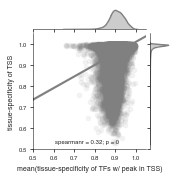

In [85]:
g = sns.jointplot(data=fimo_114_grp_all, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0.5, 1.05), ylim=(0.5,1.05), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(tissue-specificity of TFs w/ peak in TSS)", "tissue-specificity of TSS")
g.savefig("fimo_allTSS_114bp_allCAGE_corr.pdf", dpi="figure", bbox_inches="tight")

## 10. limit to pool1 tss only

In [86]:
fimo_filt = fimo_ts[fimo_ts["tss_id"].isin(pool1_annot["TSS_id"])]
fimo_filt.head()

,#pattern name,short_description,tss_id,shuffled,start,stop,strand,score,p-value,q-value,matched sequence,motif_id,biotype,tissue_spec_all_cage,tissue_spec_three_cage,motif_upper,tf,TF_tissue_spec_all,TF_tissue_spec_three
55,RUNX1,p1@ENST00000412759,"chr1:120838328..120838358,-",NaN,169,179,-,15.6034,2.490000e-07,0.33800,GTCTGTGGTTT,RUNX1,div_lnc,0.800591,0.17926,RUNX1,RUNX1,0.889490,0.413074
56,PAX5,p1@ENST00000412759,"chr1:120838328..120838358,-",NaN,2853,2871,-,14.1452,7.260000e-06,0.12600,GGGTTCAGGCGAGCGGGAA,PAX5,div_lnc,0.800591,0.17926,PAX5,PAX5,0.989766,NaN
57,NFYA,p1@ENST00000412759,"chr1:120838328..120838358,-",NaN,1543,1560,+,13.9512,7.300000e-06,0.32300,TCCGATCTCATTGGCCGG,NFYA,div_lnc,0.800591,0.17926,NFYA,NFYA,0.834341,0.320292
58,NFYA,p1@ENST00000412759,"chr1:120838328..120838358,-",NaN,1945,1962,+,13.8415,7.750000e-06,0.33200,CGGGCGGTGATTGGTAAA,NFYA,div_lnc,0.800591,0.17926,NFYA,NFYA,0.834341,0.320292
59,SP1,p1@ENST00000412759,"chr1:120838328..120838358,-",NaN,932,942,+,18.1154,1.700000e-07,0.00548,GCCCCTCCCCC,SP1,div_lnc,0.800591,0.17926,SP1,SP1,0.789165,0.381729


In [87]:
len(fimo_filt)

51808

In [88]:
fimo_114_filt = fimo_114_ts[fimo_114_ts["tss_id"].isin(pool1_annot["TSS_id"])]
len(fimo_114_filt)

26401

In [89]:
chip_filt = chip_ts[chip_ts["tss_id"].isin(pool1_annot["TSS_id"])]
len(chip_filt)

162958

In [90]:
chip_114_filt = chip_114_ts[chip_114_ts["tss_id"].isin(pool1_annot["TSS_id"])]
len(chip_114_filt)

42408

In [92]:
fimo_filt_grp_all = fimo_filt.groupby(["tss_id", "tissue_spec_all_cage"])["TF_tissue_spec_all"].agg(["mean", "count"]).reset_index()
fimo_filt_grp_all.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]

In [93]:
fimo_filt_grp_3 = fimo_filt.groupby(["tss_id", "tissue_spec_three_cage"])["TF_tissue_spec_three"].agg(["mean", "count"]).reset_index()
fimo_filt_grp_3.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]

In [94]:
fimo_114_filt_grp_all = fimo_114_filt.groupby(["tss_id", "tissue_spec_all_cage"])["TF_tissue_spec_all"].agg(["mean", "count"]).reset_index()
fimo_114_filt_grp_all.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]

In [95]:
fimo_114_filt_grp_3 = fimo_114_filt.groupby(["tss_id", "tissue_spec_three_cage"])["TF_tissue_spec_three"].agg(["mean", "count"]).reset_index()
fimo_114_filt_grp_3.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]

In [96]:
chip_filt_grp_all = chip_filt.groupby(["tss_id", "tissue_spec_all_cage"])["TF_tissue_spec_all"].agg(["mean", "count"]).reset_index()
chip_filt_grp_all.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]

In [97]:
chip_filt_grp_3 = chip_filt.groupby(["tss_id", "tissue_spec_three_cage"])["TF_tissue_spec_three"].agg(["mean", "count"]).reset_index()
chip_filt_grp_3.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]

In [98]:
chip_114_filt_grp_all = chip_114_filt.groupby(["tss_id", "tissue_spec_all_cage"])["TF_tissue_spec_all"].agg(["mean", "count"]).reset_index()
chip_114_filt_grp_all.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]

In [99]:
chip_114_filt_grp_3 = chip_114_filt.groupby(["tss_id", "tissue_spec_three_cage"])["TF_tissue_spec_three"].agg(["mean", "count"]).reset_index()
chip_114_filt_grp_3.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]

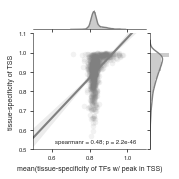

In [101]:
g = sns.jointplot(data=chip_filt_grp_all, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0.5, 1.1), ylim=(0.5,1.1), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(tissue-specificity of TFs w/ peak in TSS)", "tissue-specificity of TSS")
g.savefig("chip_pool1TSS_3kb_allCAGE_corr.pdf", dpi="figure", bbox_inches="tight")

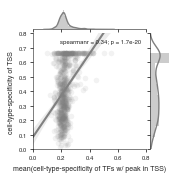

In [103]:
g = sns.jointplot(data=chip_filt_grp_3, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0, 0.8), ylim=(0,0.8), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(cell-type-specificity of TFs w/ peak in TSS)", "cell-type-specificity of TSS")
g.savefig("chip_pool1TSS_3kb_3CAGE_corr.pdf", dpi="figure", bbox_inches="tight")

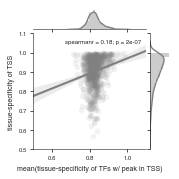

In [104]:
g = sns.jointplot(data=chip_114_filt_grp_all, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0.5, 1.1), ylim=(0.5,1.1), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(tissue-specificity of TFs w/ peak in TSS)", "tissue-specificity of TSS")
g.savefig("chip_pool1TSS_114bp_allCAGE_corr.pdf", dpi="figure", bbox_inches="tight")

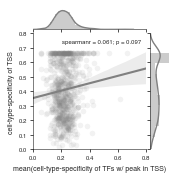

In [105]:
g = sns.jointplot(data=chip_114_filt_grp_3, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0, 0.8), ylim=(0,0.8), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(cell-type-specificity of TFs w/ peak in TSS)", "cell-type-specificity of TSS")
g.savefig("chip_pool1TSS_114bp_3CAGE_corr.pdf", dpi="figure", bbox_inches="tight")

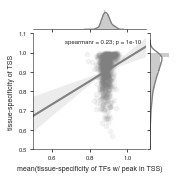

In [106]:
g = sns.jointplot(data=fimo_filt_grp_all, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0.5, 1.1), ylim=(0.5,1.1), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(tissue-specificity of TFs w/ peak in TSS)", "tissue-specificity of TSS")
g.savefig("fimo_pool1TSS_3kb_allCAGE_corr.pdf", dpi="figure", bbox_inches="tight")

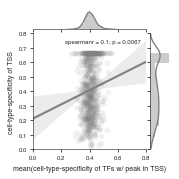

In [107]:
g = sns.jointplot(data=fimo_filt_grp_3, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0, 0.8), ylim=(0,0.8), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(cell-type-specificity of TFs w/ peak in TSS)", "cell-type-specificity of TSS")
g.savefig("fimo_pool1TSS_3kb_3CAGE_corr.pdf", dpi="figure", bbox_inches="tight")

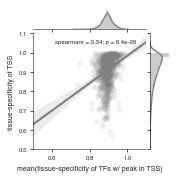

In [108]:
g = sns.jointplot(data=fimo_114_filt_grp_all, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0.5, 1.1), ylim=(0.5,1.1), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(tissue-specificity of TFs w/ peak in TSS)", "tissue-specificity of TSS")
g.savefig("fimo_pool1TSS_114bp_allCAGE_corr.pdf", dpi="figure", bbox_inches="tight")

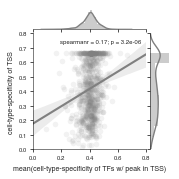

In [109]:
g = sns.jointplot(data=fimo_114_filt_grp_3, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0, 0.8), ylim=(0,0.8), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(cell-type-specificity of TFs w/ peak in TSS)", "cell-type-specificity of TSS")
g.savefig("fimo_pool1TSS_114bp_3CAGE_corr.pdf", dpi="figure", bbox_inches="tight")

## 11. re-do MPRA tissue-sp

In [110]:
coverage = pd.read_table("../../data/04__coverage/motif_coverage.txt", sep="\t")
coverage.head()

,unique_id,MPRA_mean_activ,MPRA_tissue_sp,avg_tf_tissue_sp,log_avg_tf_tissue_sp,num_motifs,log_num_motifs,num_bp_covered,log_num_bp_covered,max_coverage,log_max_coverage
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,-1.974712,0.386721,0.249383,0.222650,10,2.397895,45,3.828641,6,1.945910
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,-0.700792,0.165019,0.416909,0.348478,53,3.988984,101,4.624973,24,3.218876
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-0.886722,0.261225,0.429598,0.357394,24,3.218876,84,4.442651,12,2.564949
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-1.445209,0.265622,0.435871,0.361772,13,2.639057,54,4.007333,9,2.302585
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,-1.062973,0.117438,0.462181,0.379929,16,2.833213,99,4.605170,5,1.791759


In [112]:
pool1_fimo = pd.read_table("../../misc/05__fimo/pool1_fimo_map.txt", sep="\t")
pool1_fimo.head()

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence
0,ZNF263,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr9:...,60,80,-,29.2449,9.790000e-13,2.160000e-07,GGAGGAGGAGGAGGAGGGGGA
1,ZNF263,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,60,80,-,29.2449,9.790000e-13,2.160000e-07,GGAGGAGGAGGAGGAGGGGGA
2,ZNF263,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,57,77,-,29.0000,1.740000e-12,2.160000e-07,GGAGGAGGAGGAGGGGGAGGA
3,ZNF263,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr9:...,57,77,-,29.0000,1.740000e-12,2.160000e-07,GGAGGAGGAGGAGGGGGAGGA
4,ZNF263,FLIPPED__Enhancer.flip.antisense__chr19:185263...,32,52,+,28.7347,2.680000e-12,2.160000e-07,GGAGGAGGAAGAGGAGGAGGG


In [113]:
pool1_fimo = pool1_fimo.merge(tf_ts, left_on="#pattern name", right_on="tf", how="left")
pool1_fimo.sample(5)

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence,tf,TF_tissue_spec_all,TF_tissue_spec_three
73350,ETV1,WILDTYPE_SNP_PLUS_HAPLO__Antisense.noflip.NA__...,29,38,-,11.7273,4.840000e-05,0.108000,AGCGGAAGCG,ETV1,0.956169,0.663507
11689,KLF14,WILDTYPE__mrna.flip.sense__chr14:35451808..354...,29,42,+,15.6724,2.910000e-06,0.011100,AGCCCCGCCCCTCT,NaN,NaN,NaN
2872,KLF5,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr11:12...,36,45,-,17.0000,3.390000e-07,0.000632,GCCCCGCCCC,KLF5,0.942557,0.658790
71663,Klf1,WILDTYPE_SNP_PLUS_HAPLO__mrna.noflip.NA__chr17...,10,20,-,11.6364,4.670000e-05,0.046900,AGCCCCGCCCC,NaN,NaN,NaN
49709,KLF16,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr13...,36,46,-,12.2586,2.670000e-05,0.012900,CCCCCACCCCT,KLF16,0.818036,0.114851


In [114]:
pool1_fimo = pool1_fimo.merge(coverage, left_on="sequence name", right_on="unique_id", how="left")
pool1_fimo.head()

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence,tf,...,MPRA_mean_activ,MPRA_tissue_sp,avg_tf_tissue_sp,log_avg_tf_tissue_sp,num_motifs,log_num_motifs,num_bp_covered,log_num_bp_covered,max_coverage,log_max_coverage
0,ZNF263,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr9:...,60,80,-,29.2449,9.790000e-13,2.160000e-07,GGAGGAGGAGGAGGAGGGGGA,ZNF263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ZNF263,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,60,80,-,29.2449,9.790000e-13,2.160000e-07,GGAGGAGGAGGAGGAGGGGGA,ZNF263,...,-0.590207,0.093358,0.292093,0.256263,53.0,3.988984,90.0,4.51086,25.0,3.258097
2,ZNF263,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,57,77,-,29.0000,1.740000e-12,2.160000e-07,GGAGGAGGAGGAGGGGGAGGA,ZNF263,...,-0.590207,0.093358,0.292093,0.256263,53.0,3.988984,90.0,4.51086,25.0,3.258097
3,ZNF263,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr9:...,57,77,-,29.0000,1.740000e-12,2.160000e-07,GGAGGAGGAGGAGGGGGAGGA,ZNF263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ZNF263,FLIPPED__Enhancer.flip.antisense__chr19:185263...,32,52,+,28.7347,2.680000e-12,2.160000e-07,GGAGGAGGAAGAGGAGGAGGG,ZNF263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
pool1_fimo_grp = pool1_fimo.groupby(["unique_id", "MPRA_tissue_sp"])["TF_tissue_spec_three"].agg(["mean", "count"]).reset_index()
pool1_fimo_grp.columns = ["tss_id", "tss_ts", "tf_ts", "tf_count"]
pool1_fimo_grp.sample(5)

,tss_id,tss_ts,tf_ts,tf_count
1306,WILDTYPE__Enhancer.flip.sense__chr6:14735225.....,0.504320,0.341265,8
935,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr8:145...,0.192537,0.442167,21
696,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr13:33...,0.136027,0.368797,32
95,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,0.190488,0.368923,32
534,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr8:...,0.466934,0.413127,19


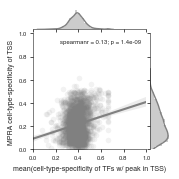

In [117]:
g = sns.jointplot(data=pool1_fimo_grp, x="tf_ts", y="tss_ts", kind="reg", size=2.5, color="gray", 
                  stat_func=spearmanr,
                  xlim=(0, 1), ylim=(0,1), joint_kws=dict(scatter_kws={'alpha':0.1}))
g.set_axis_labels("mean(cell-type-specificity of TFs w/ peak in TSS)", "MPRA cell-type-specificity of TSS")
g.savefig("MPRA_spec_fimo_pool1TSS_114bp_3CAGE_corr.pdf", dpi="figure", bbox_inches="tight")